# Finite element basic and not optimized  Python implementation

In [115]:
from numpy import * 

from scipy import *
from scipy.linalg import *

from scipy import interpolate
from scipy.interpolate import griddata

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.tri as tri


## Triangulation refinement

This is the function that handles the red refinement for our triangulations. The inputs are the coordinates for vertices, the triangles and the boundary edges. It returns those same things after one iteration of the refinement. I will explain more about this in the examples.

In [116]:
def red_refinement(x,y,triangles,boundary):
####################################################
# Red refinement for triangulations
# New traingle from middle points of edges.
####################################################
#INPUT
####################################################
# x  ................... Vertices x coordinates
# y  ................... Vertices x coordinates
# triangles ............ For each triangle the node 
#                        numbers of the vertices e.g. 
#                        [1,2,3].
# boundary ............. For each boundary edge the 
#                        node numbers of the vertices
#                         e.g.[1,2,3].
####################################################
#OUTPUT
####################################################
# x  ................... Same as input after one
# y  ................... iteration of the red 
# triangles ............ refinement.
# boundary .............
####################################################
    coordinates = vstack((x,y))
    
    ## Boundary Edges
    x_end = (x[-1]+x[0])/2
    y_end = (y[-1]+y[0])/2

    xm = []
    ym = []
    for i in range(len(x)-1):
        xm.extend([(x[i]+x[i+1])/2 ])
        ym.extend([(y[i]+y[i+1])/2 ])

    xm.extend([x_end]) 
    ym.extend([y_end]) 

    edge_x = []
    edge_y = [] 
    for i in range(-1,len(x)-1):
        edge_x.extend([x[i],xm[i],xm[i],x[i+1]])
        edge_y.extend([y[i],ym[i],ym[i],y[i+1]])

    Boundary = vstack((edge_x,edge_y))


    ## New triangles 
    Triangles = []
    Coordinates = []
    for j in range(len(triangles)):

        tx = coordinates[:,triangles[j]][0,:]
        ty = coordinates[:,triangles[j]][1,:]           

        ntx = vstack(([tx[0], (tx[0] + tx[1])/2, (tx[0] + tx[2])/2],
        [tx[1], (tx[1] + tx[2])/2, (tx[1] + tx[0])/2],
        [tx[2], (tx[2] + tx[0])/2, (tx[2] + tx[1])/2]))

        nty = vstack(([ty[0], (ty[0] + ty[1])/2, (ty[0] + ty[2])/2],
        [ty[1], (ty[1] + ty[2])/2, (ty[1] + ty[0])/2],
        [ty[2], (ty[2] + ty[0])/2, (ty[2] + ty[1])/2]))

        t0 = vstack((ntx[0,:],nty[0,:]))
        t1 = vstack((ntx[1,:],nty[1,:]))
        t2 = vstack((ntx[2,:],nty[2,:]))
        t3 = vstack((ntx[:,2],nty[:,2]))

        Triangles.extend((t0,t1,t2,t3))

    ## New coordinates
    for i in range(size(Triangles,0)):
        coordinates = concatenate((coordinates,Triangles[i]),axis=1)

    Coordinates = unique(coordinates ,axis=1) 

    
    ## Coordinates to Vertices for boundary
    boundary_list = []
    for i in range(size(Boundary,1)):
            for k in range(size(Coordinates,1)):
                if (Boundary[:,i] == Coordinates[:,k]).all():
                    boundary_list.extend([k])

    Boundary = [boundary_list[x:x+2] for x in range(0, len(boundary_list),2)]   

    
    ## Coordinates to Vertices for triangles
    triangles_list =[]
    for i in range(len(Triangles)):
        T =[0,0,0]
        for j in [0,1,2]:
            for k in range(size(Coordinates,1)):
                if (Triangles[i][:,j] == Coordinates[:,k]).all():
                    T[j] = k
        triangles_list.append(T)  

        
    ## Renaming variables
    triangles = triangles_list
    boundary = Boundary
    coordinates = Coordinates
    x = coordinates[0,:].tolist()
    y = coordinates[1,:].tolist()
    
    return x, y, triangles, boundary

### Refinement examples

Here we are using matplolib triagulation function only to plot our triangulations. Our first example is just one triangle:

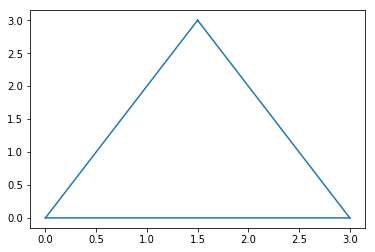

In [117]:
x = [0,  3 , 1.5]
y = [0,  0 ,  3 ]
triangles = [ [0,1,2] ]
boundary = [[0,1], [1,2], [2,0]]
triang = tri.Triangulation(x, y, triangles)
plt.triplot(triang)

Observe that $x$ and $y$ are the vetices coordinates. They trivially induce an order on the vertices i.e. vertex $0$ is at $(0,0)$, vertex $1$ is at $(3,0)$ and vertex $2$ is at $(1.5,3)$. Following this naming, we can specify triangles as $[0,1,2]$ where entries are the vertices in anticlockwise order. The same holds for edges and in particular for boundary edges. Now, when calling our function on these values we obtain:

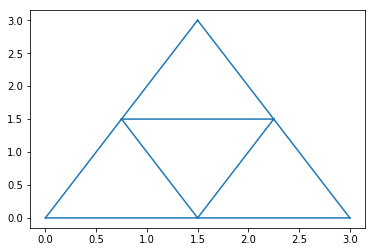

In [118]:
x, y, triangles, boundary = red_refinement(x, y, triangles, boundary)
triang = tri.Triangulation(x, y, triangles)
plt.triplot(triang)

The new vertices are at the middle points of the original vertices. This is red refinement. Observe that our new coordinates are:

In [119]:
vstack((x, y))

array([[0.  , 0.75, 1.5 , 1.5 , 2.25, 3.  ],
       [0.  , 1.5 , 0.  , 3.  , 1.5 , 0.  ]])

We respect to this order on the vertices coordinates, the new four triangles are:

In [120]:
triangles

[[0, 2, 1], [5, 4, 2], [3, 1, 4], [1, 2, 4]]

and the six boundary edges are:

In [121]:
boundary

[[3, 1], [1, 0], [0, 2], [2, 5], [5, 4], [4, 3]]

Now, let's run our function one more time.

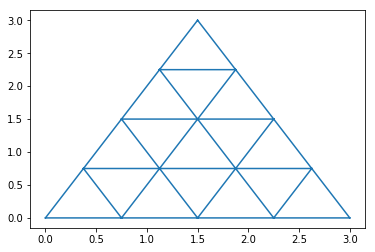

In [122]:
x, y, triangles, boundary = red_refinement(x, y, triangles, boundary)
triang = tri.Triangulation(x, y, triangles)
plt.triplot(triang)

One last time:

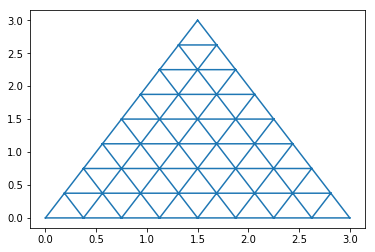

In [123]:
x, y, triangles, boundary = red_refinement(x, y, triangles, boundary)
triang = tri.Triangulation(x, y, triangles)
plt.triplot(triang)

Observe that our function handles other domains as well. For example, a square:

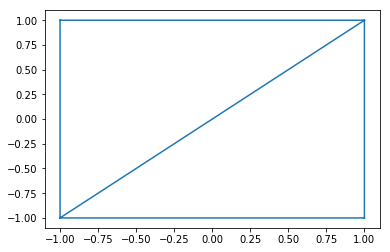

In [124]:
x = [-1,  1 , 1, -1]
y = [-1,  -1 , 1, 1]
triangles = [ [0,1,2], [0,2,3] ]
boundary = [[0,1], [1,3], [2,0], [2,3]]
triang = tri.Triangulation(x, y, triangles)
plt.triplot(triang)

In [125]:
for i in range(4):
    x, y, triangles, boundary = red_refinement(x, y, triangles, boundary)
    triang = tri.Triangulation(x, y, triangles)
    

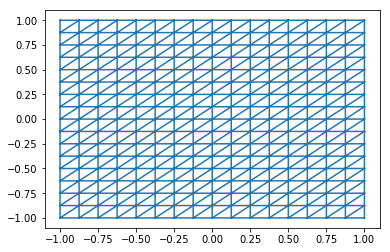

In [126]:
plt.triplot(triang)

Observe that 5 refinement iterations take already some time to complete. This is just a naive impletation for the red refinement. It clear that we can improve it to get better results. 

This implementation can handle L-shaped domains as well:

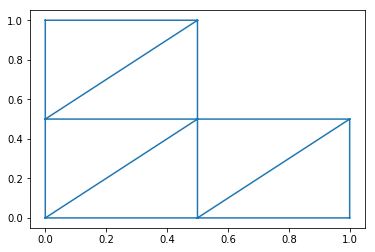

In [127]:
x = [0, .5, 1 ,  0, .5,  1, 0, .5]
y = [0,  0, 0 , .5, .5, .5, 1, 1]
triangles = [ [0,1,4], [1,2,5], [0,4,3], [1,5,4], [3,4,7], [3,7,6] ]
boundary = [[0,1], [1,2], [2,5], [4,5],[4,7],[6,7],[3,6],[0,3]]
triang = tri.Triangulation(x, y, triangles)
plt.triplot(triang)

In [128]:
for i in range(3):
    x, y, triangles, boundary = red_refinement(x, y, triangles, boundary)
    triang = tri.Triangulation(x, y, triangles)    

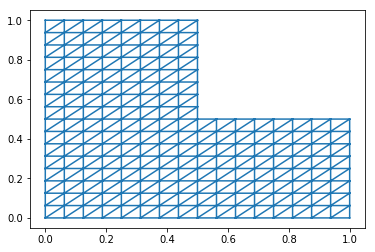

In [129]:
plt.triplot(triang)

Note: I have included this examples because it took me a long time to get the refinement working properly.

## Finite element on a square domain

This finite element implementation is based on J. Alberty, C. Carstensen & S.A. Funken. Remarks around 50 lines of Matlab. I run their Matlab's code to compare with my results. 

We are working on the square $\Omega = [-1,1] \times [-1,1]$. Using only two triangles, we can describe our domain as:

In [201]:
x = [-1,  1 , 1, -1]
y = [-1,  -1 , 1, 1]
triangles = [ [0,1,2], [0,2,3] ]
boundary = [[0,1], [1,3], [2,0], [2,3]]

Now, we apply our refinement function 3 and plot the resulting triangulation

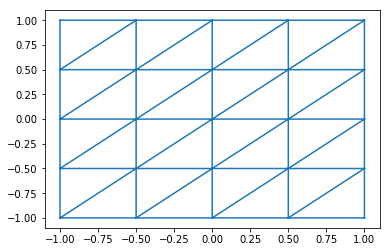

In [202]:
for i in range(2):
    x, y, triangles, boundary = red_refinement(x, y, triangles, boundary)
    triang = tri.Triangulation(x, y, triangles)
plt.triplot(triang)        

Renaming variables we have:

In [203]:
coordinates = vstack((x,y))
coordinates= transpose(coordinates)

elements = triangles

dirichlet = transpose(boundary)
dirichlet = transpose(dirichlet)

Observe that for convenience we also reshaped them into columns.

### Boundary value problem

We are solving the following boundary value problem:

\begin{equation}
  \left\{\begin{matrix}
    -\Delta u = f \quad in \quad \Omega \\ 
    u=g \quad on \quad \delta\Omega
    \end{matrix}\right.
\end{equation}

For this example, we choose data such that the exact solution is

\begin{equation}
    u(x,y) = \cos(\pi x) \cos(\pi y)
\end{equation}

Thus, the forcing term and boundary values function are given by:

In [204]:
def f(x):
    # Frocing term
    VolumeForce = -2*cos(pi*x[0])*cos(pi*x[1])*(pi**2)
    return VolumeForce

def  u_d(x):
    # values at the boundary. Accepts vertices coordinates
    DirichletBoundaryValue = zeros((size(x,0),1) ) 
    for j in range(size(x,0)):
        DirichletBoundaryValue[j] = cos(pi*x[j][0])*cos(pi*x[j][1])
    return  DirichletBoundaryValue   

The exact solution is 

In [258]:
def  u_E(x):
    # Exact Solution, accepts an array.
    u = zeros((size(x,0),1) ) 
    u = cos(pi*x[:,0])*cos(pi*x[:,1])
    return  transpose(u).tolist() 

We calculate the stiffness matrix with the next routine:

In [206]:
def stifmatrix(vertices):
  # Stiffness Matrix  
  d = 2
  A =  vstack((ones((1,d+1)),transpose(vertices)) )
  b =  vstack((zeros((1,d)),eye(2)))
  G =  solve(A, b)
  M =  det(A)*G@transpose(G)/2 
  return M

Now we are in position to assemble and solve our problem:

In [207]:
# Assembly
A = zeros((size(coordinates,0),size(coordinates,0)))
for j in range(size(elements,0)):
    A[c_[elements[j]], elements[j]] = A[c_[elements[j]], elements[j]] + stifmatrix(coordinates[elements[j],:])

# Volume Forces
b = zeros((size(coordinates,0),1))
for j in range(size(elements,0)):
    b[elements[j]] =  b[elements[j]] + det(vstack(( [1,1,1] ,transpose(coordinates[elements[j],:]) )) )*f(sum(coordinates[elements[j]],0)/3)/6   
    
# Dirichlet Conditions
u =zeros((size(coordinates,0),1))
u[unique(dirichlet)] = u_d(coordinates[unique(dirichlet)])
b = b - A@u     

# Solving linear System
FreeNodes=setdiff1d(asarray([range((size(coordinates,0)))]),unique(dirichlet))
u[FreeNodes]=solve(A[:,FreeNodes][FreeNodes,:],b[FreeNodes])




Finally, we plot the results:

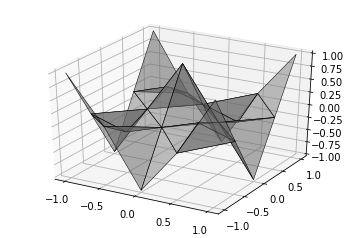

In [208]:
z= transpose(u).tolist()[0]
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_trisurf(x,y, z, lw=0.5, edgecolor="black", color="grey",alpha=0.5)

plt.xticks([-1,-.5,0,.5,1])
plt.yticks([-1,-.5,0,.5,1])

plt.show()

Now, let's compare with the exact solution. To this end, we interpolate the exact solution and approximate solution using python linear interpolation.

In [209]:
points=column_stack((x,y))
z_E = u_E(points)
grid_x, grid_y = mgrid[-1:1:100j, -1:1:200j]
grid_Ap = griddata(points, z, (grid_x, grid_y), method='linear')
grid_E  = griddata(points, z_E, (grid_x, grid_y), method='linear')

This is the real solution :

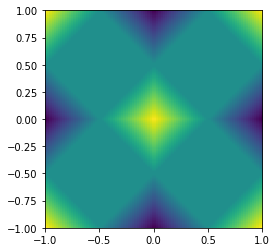

In [210]:
plt.imshow(grid_E.T, extent=(-1,1,-1,1))

This is the approximate solution:

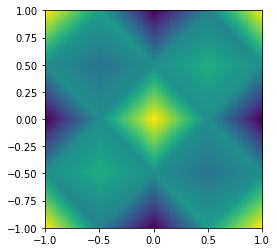

In [211]:
plt.imshow(grid_Ap.T, extent=(-1,1,-1,1))

Lat's see what happens when we use a triagulation with 32 triangle edges per square side:

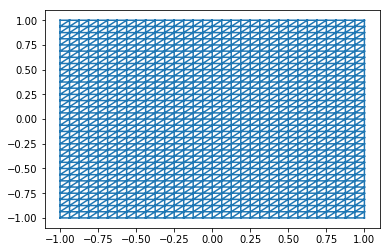

In [212]:
x = [-1,  1 , 1, -1]
y = [-1,  -1 , 1, 1]
triangles = [ [0,1,2], [0,2,3] ]
boundary = [[0,1], [1,3], [2,0], [2,3]]

for i in range(5):
    x, y, triangles, boundary = red_refinement(x, y, triangles, boundary)
    triang = tri.Triangulation(x, y, triangles)
plt.triplot(triang)  

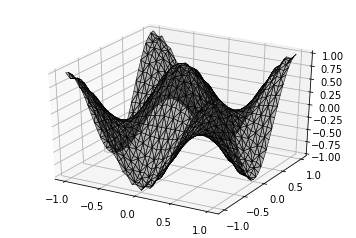

In [142]:
coordinates = vstack((x,y))
coordinates= transpose(coordinates)

elements = triangles

dirichlet = transpose(boundary)
dirichlet = transpose(dirichlet)

# Assembly
A = zeros((size(coordinates,0),size(coordinates,0)))
for j in range(size(elements,0)):
    A[c_[elements[j]], elements[j]] = A[c_[elements[j]], elements[j]] + stifmatrix(coordinates[elements[j],:])

# Volume Forces
b = zeros((size(coordinates,0),1))
for j in range(size(elements,0)):
    b[elements[j]] =  b[elements[j]] + det(vstack(( [1,1,1] ,transpose(coordinates[elements[j],:]) )) )*f(sum(coordinates[elements[j]],0)/3)/6   
    
# Dirichlet Conditions
u =zeros((size(coordinates,0),1))
u[unique(dirichlet)] = u_d(coordinates[unique(dirichlet)])
b = b - A@u     

# Solving linear System
FreeNodes=setdiff1d(asarray([range((size(coordinates,0)))]),unique(dirichlet))
u[FreeNodes]=solve(A[:,FreeNodes][FreeNodes,:],b[FreeNodes])

# Plotting
z= transpose(u).tolist()[0]
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_trisurf(x,y, z, lw=0.5, edgecolor="black", color="grey",alpha=0.5)

plt.xticks([-1,-.5,0,.5,1])
plt.yticks([-1,-.5,0,.5,1])

plt.show()

In [143]:
points=column_stack((x,y))
z_E = u_E(points)
grid_x, grid_y = mgrid[-1:1:100j, -1:1:200j]
grid_Ap = griddata(points, z, (grid_x, grid_y), method='linear')
grid_E  = griddata(points, z_E, (grid_x, grid_y), method='linear')

This is the real solution :



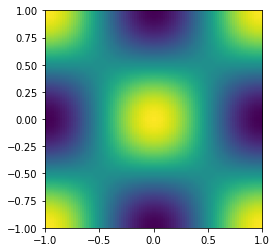

In [144]:
plt.imshow(grid_E.T, extent=(-1,1,-1,1))

This is the approximate solution:

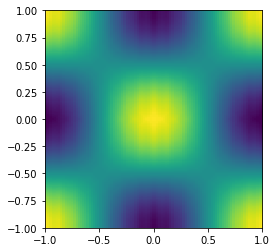

In [145]:
plt.imshow(grid_Ap.T, extent=(-1,1,-1,1))

## Error Calculation

We start taking the next triangulation over the square:

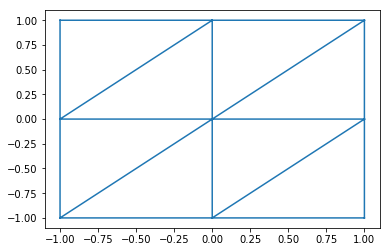

In [391]:
x = [-1,  1 , 1, -1]
y = [-1,  -1 , 1, 1]
triangles = [ [0,1,2], [0,2,3] ]
boundary = [[0,1], [1,3], [2,0], [2,3]]

for i in range(1):
    x, y, triangles, boundary = red_refinement(x, y, triangles, boundary)
    triang = tri.Triangulation(x, y, triangles)
plt.triplot(triang)        

Calculating the approximate solution:

In [392]:
coordinates = vstack((x,y))
coordinates= transpose(coordinates)

elements = triangles

dirichlet = transpose(boundary)
dirichlet = transpose(dirichlet)

# Assembly
A = zeros((size(coordinates,0),size(coordinates,0)))
for j in range(size(elements,0)):
    A[c_[elements[j]], elements[j]] = A[c_[elements[j]], elements[j]] + stifmatrix(coordinates[elements[j],:])

# Volume Forces
b = zeros((size(coordinates,0),1))
for j in range(size(elements,0)):
    b[elements[j]] =  b[elements[j]] + det(vstack(( [1,1,1] ,transpose(coordinates[elements[j],:]) )) )*f(sum(coordinates[elements[j]],0)/3)/6   
    
# Dirichlet Conditions
u =zeros((size(coordinates,0),1))
u[unique(dirichlet)] = u_d(coordinates[unique(dirichlet)])
b = b - A@u     

# Solving linear System
FreeNodes=setdiff1d(asarray([range((size(coordinates,0)))]),unique(dirichlet))
u[FreeNodes]=solve(A[:,FreeNodes][FreeNodes,:],b[FreeNodes])


Now, we need to calculate the integrals of the squared error function and the squared gradient norm error funtion over each element. The process is basically the same as constructing stiffness and mass matrices. First we need a way to find the values for u at points that are not vertices. Since we are using linear interpolation, we can calculate the plane through each element:

In [393]:
# Find the value at (x,y) for u from values at vertices (x1, y1, z1), (x2, y2, z2), (x3, y3, z3)
def plane(x,x1,y1,z1, x2, y2, z2, x3, y3, z3):  
    a1 = x2 - x1 
    b1 = y2 - y1 
    c1 = z2 - z1 
    a2 = x3 - x1 
    b2 = y3 - y1 
    c2 = z3 - z1 
    a = b1 * c2 - b2 * c1 
    b = a2 * c1 - a1 * c2 
    c = a1 * b2 - b1 * a2 
    d = (- a * x1 - b * y1 - c * z1) 
    return (1/c)*(-a*x[0]-b*x[1]-d)

First we calculate L2 error norm: 

In [394]:
L2_norm = 0
for j in range(size(elements,0)):
    
    vertices = coordinates[elements[j],:]
    M = column_stack((ones((3,1)),vertices))

    x1 = vertices[0,0]
    x2 = vertices[1,0]
    x3 = vertices[2,0]

    y1 = vertices[0,1]
    y2 = vertices[1,1]
    y3 = vertices[2,1]

    z1 = u[elements[j],:][0]
    z2 = u[elements[j],:][1]
    z3 = u[elements[j],:][2]

    # Quadrature rule degree 2
    X1 = 2/3*vertices[0] + 1/6*vertices[1] + 1/6*vertices[2]
    X2 = 1/6*vertices[0] + 2/3*vertices[1] + 1/6*vertices[2]
    X3 = 1/6*vertices[0] + 1/6*vertices[1] + 2/3*vertices[2]

    # u at quadrature points
    uat_X1 = plane(X1,x1,y1,z1, x2, y2, z2, x3, y3, z3)
    uat_X2 = plane(X2,x1,y1,z1, x2, y2, z2, x3, y3, z3)
    uat_X3 = plane(X2,x1,y1,z1, x2, y2, z2, x3, y3, z3)


    # Exact solution
    uEat_X1 = cos(pi*X1[0])*cos(pi*X1[1])
    uEat_X2 = cos(pi*X1[0])*cos(pi*X1[1])
    uEat_X3 = cos(pi*X1[0])*cos(pi*X1[1])

    L2_norm = L2_norm + 1/6*abs(det(transpose(M)))*((uEat_X1-uat_X1)**2 + (uEat_X2-uat_X2)**2  + (uEat_X3-uat_X3)**2)
 

L2_norm = sqrt(L2_norm) 
L2_norm


array([1.98370569])

Now, the H1 seminorm error:

In [395]:
# Find the square norm of gradient for the plane through (x1, y1, z1), (x2, y2, z2), (x3, y3, z3)
def plane_gradient(x1,y1,z1, x2, y2, z2, x3, y3, z3):  
    a1 = x2 - x1 
    b1 = y2 - y1 
    c1 = z2 - z1 
    a2 = x3 - x1 
    b2 = y3 - y1 
    c2 = z3 - z1 
    a = b1 * c2 - b2 * c1 
    b = a2 * c1 - a1 * c2 
    c = a1 * b2 - b1 * a2 
    return (a*b/(c**2))

In [396]:
H1_sn = 0
for j in range(size(elements,0)):
    
    vertices = coordinates[elements[j],:]
    M = column_stack((ones((3,1)),vertices))

    x1 = vertices[0,0]
    x2 = vertices[1,0]
    x3 = vertices[2,0]

    y1 = vertices[0,1]
    y2 = vertices[1,1]
    y3 = vertices[2,1]

    z1 = u[elements[j],:][0]
    z2 = u[elements[j],:][1]
    z3 = u[elements[j],:][2]

    # Quadrature rule degree 1 (center of mass)
    X1 = 1/3*vertices[0] + 1/3*vertices[1] + 1/3*vertices[2]
   

    GdotG = plane_gradient(x1,y1,z1, x2, y2, z2, x3, y3, z3)

    # Exact solution gradient
    uEat_X1 = (pi*cos(pi*X1[1])*sin(pi*X1[0]))**2 + (pi*cos(pi*X1[0])*sin(pi*X1[1]))**2 


    H1_sn = H1_sn + 1/2*abs(det(transpose(M)))*((GdotG-uEat_X1)**2 )
 
H1_sn = sqrt(H1_sn)
H1_sn


array([10.73363291])

 Finally we calculate H1 error norm:


In [386]:
H1_norm = sqrt(L2_norm + H1_sn)
H1_norm

array([3.56613777])

We repeat this for one iteration of the refinement:

In [388]:
x = [-1,  1 , 1, -1]
y = [-1,  -1 , 1, 1]
triangles = [ [0,1,2], [0,2,3] ]
boundary = [[0,1], [1,3], [2,0], [2,3]]

for i in range(2):
    x, y, triangles, boundary = red_refinement(x, y, triangles, boundary)
    triang = tri.Triangulation(x, y, triangles)

coordinates = vstack((x,y))
coordinates= transpose(coordinates)

elements = triangles

dirichlet = transpose(boundary)
dirichlet = transpose(dirichlet)

# Assembly
A = zeros((size(coordinates,0),size(coordinates,0)))
for j in range(size(elements,0)):
    A[c_[elements[j]], elements[j]] = A[c_[elements[j]], elements[j]] + stifmatrix(coordinates[elements[j],:])

M = zeros((size(coordinates,0),size(coordinates,0)))
for j in range(size(elements,0)):
    M[c_[elements[j]], elements[j]] = M[c_[elements[j]], elements[j]] + massmatrix(coordinates[elements[j],:])   
    
    
# Volume Forces
b = zeros((size(coordinates,0),1))
for j in range(size(elements,0)):
    b[elements[j]] =  b[elements[j]] + det(vstack(( [1,1,1] ,transpose(coordinates[elements[j],:]) )) )*f(sum(coordinates[elements[j]],0)/3)/6   
    
# Dirichlet Conditions
u =zeros((size(coordinates,0),1))
u[unique(dirichlet)] = u_d(coordinates[unique(dirichlet)])
b = b - A@u     

# Solving linear System
FreeNodes=setdiff1d(asarray([range((size(coordinates,0)))]),unique(dirichlet))
u[FreeNodes]=solve(A[:,FreeNodes][FreeNodes,:],b[FreeNodes])

L2_norm = 0
# L2 norm
for j in range(size(elements,0)):
    
    vertices = coordinates[elements[j],:]
    M = column_stack((ones((3,1)),vertices))

    x1 = vertices[0,0]
    x2 = vertices[1,0]
    x3 = vertices[2,0]

    y1 = vertices[0,1]
    y2 = vertices[1,1]
    y3 = vertices[2,1]

    z1 = u[elements[j],:][0]
    z2 = u[elements[j],:][1]
    z3 = u[elements[j],:][2]

    # Quadrature rule degree 2
    X1 = 2/3*vertices[0] + 1/6*vertices[1] + 1/6*vertices[2]
    X2 = 1/6*vertices[0] + 2/3*vertices[1] + 1/6*vertices[2]
    X3 = 1/6*vertices[0] + 1/6*vertices[1] + 2/3*vertices[2]

    # u at quadrature points
    uat_X1 = plane(X1,x1,y1,z1, x2, y2, z2, x3, y3, z3)
    uat_X2 = plane(X2,x1,y1,z1, x2, y2, z2, x3, y3, z3)
    uat_X3 = plane(X2,x1,y1,z1, x2, y2, z2, x3, y3, z3)


    # Exact solution
    uEat_X1 = cos(pi*X1[0])*cos(pi*X1[1])
    uEat_X2 = cos(pi*X1[0])*cos(pi*X1[1])
    uEat_X3 = cos(pi*X1[0])*cos(pi*X1[1])

    L2_norm = L2_norm + 1/6*abs(det(transpose(M)))*((uEat_X1-uat_X1)**2 + (uEat_X2-uat_X2)**2  + (uEat_X3-uat_X3)**2)

L2_norm = sqrt(L2_norm)    

H1_sn = 0
# H1 norm
for j in range(size(elements,0)):
    
    vertices = coordinates[elements[j],:]
    M = column_stack((ones((3,1)),vertices))

    x1 = vertices[0,0]
    x2 = vertices[1,0]
    x3 = vertices[2,0]

    y1 = vertices[0,1]
    y2 = vertices[1,1]
    y3 = vertices[2,1]

    z1 = u[elements[j],:][0]
    z2 = u[elements[j],:][1]
    z3 = u[elements[j],:][2]

    # Quadrature rule degree 1 (center of mass)
    X1 = 1/3*vertices[0] + 1/3*vertices[1] + 1/3*vertices[2]
   

    GdotG = plane_gradient(x1,y1,z1, x2, y2, z2, x3, y3, z3)

    # Exact solution gradient
    uEat_X1 = (pi**2)*((cos(pi*X1[1])*sin(pi*X1[0]))**2 + (cos(pi*X1[0])*sin(pi*X1[1]))**2 )


    H1_sn = H1_sn + 1/2*abs(det(transpose(M)))*((GdotG-uEat_X1)**2 )
 
H1_sn = sqrt(H1_sn)

H1_norm = sqrt(L2_norm + H1_sn)
H1_norm

array([3.55425119])

One more time for 4 iterations:

In [389]:
x = [-1,  1 , 1, -1]
y = [-1,  -1 , 1, 1]
triangles = [ [0,1,2], [0,2,3] ]
boundary = [[0,1], [1,3], [2,0], [2,3]]

for i in range(5):
    x, y, triangles, boundary = red_refinement(x, y, triangles, boundary)
    triang = tri.Triangulation(x, y, triangles)

coordinates = vstack((x,y))
coordinates= transpose(coordinates)

elements = triangles

dirichlet = transpose(boundary)
dirichlet = transpose(dirichlet)

# Assembly
A = zeros((size(coordinates,0),size(coordinates,0)))
for j in range(size(elements,0)):
    A[c_[elements[j]], elements[j]] = A[c_[elements[j]], elements[j]] + stifmatrix(coordinates[elements[j],:])

M = zeros((size(coordinates,0),size(coordinates,0)))
for j in range(size(elements,0)):
    M[c_[elements[j]], elements[j]] = M[c_[elements[j]], elements[j]] + massmatrix(coordinates[elements[j],:])   
    
    
# Volume Forces
b = zeros((size(coordinates,0),1))
for j in range(size(elements,0)):
    b[elements[j]] =  b[elements[j]] + det(vstack(( [1,1,1] ,transpose(coordinates[elements[j],:]) )) )*f(sum(coordinates[elements[j]],0)/3)/6   
    
# Dirichlet Conditions
u =zeros((size(coordinates,0),1))
u[unique(dirichlet)] = u_d(coordinates[unique(dirichlet)])
b = b - A@u     

# Solving linear System
FreeNodes=setdiff1d(asarray([range((size(coordinates,0)))]),unique(dirichlet))
u[FreeNodes]=solve(A[:,FreeNodes][FreeNodes,:],b[FreeNodes])

L2_norm = 0
# L2 norm
for j in range(size(elements,0)):
    
    vertices = coordinates[elements[j],:]
    M = column_stack((ones((3,1)),vertices))

    x1 = vertices[0,0]
    x2 = vertices[1,0]
    x3 = vertices[2,0]

    y1 = vertices[0,1]
    y2 = vertices[1,1]
    y3 = vertices[2,1]

    z1 = u[elements[j],:][0]
    z2 = u[elements[j],:][1]
    z3 = u[elements[j],:][2]

    # Quadrature rule degree 2
    X1 = 2/3*vertices[0] + 1/6*vertices[1] + 1/6*vertices[2]
    X2 = 1/6*vertices[0] + 2/3*vertices[1] + 1/6*vertices[2]
    X3 = 1/6*vertices[0] + 1/6*vertices[1] + 2/3*vertices[2]

    # u at quadrature points
    uat_X1 = plane(X1,x1,y1,z1, x2, y2, z2, x3, y3, z3)
    uat_X2 = plane(X2,x1,y1,z1, x2, y2, z2, x3, y3, z3)
    uat_X3 = plane(X2,x1,y1,z1, x2, y2, z2, x3, y3, z3)


    # Exact solution
    uEat_X1 = cos(pi*X1[0])*cos(pi*X1[1])
    uEat_X2 = cos(pi*X1[0])*cos(pi*X1[1])
    uEat_X3 = cos(pi*X1[0])*cos(pi*X1[1])

    L2_norm = L2_norm + 1/6*abs(det(transpose(M)))*((uEat_X1-uat_X1)**2 + (uEat_X2-uat_X2)**2  + (uEat_X3-uat_X3)**2)

L2_norm = sqrt(L2_norm)    

H1_sn = 0
# H1 norm
for j in range(size(elements,0)):
    
    vertices = coordinates[elements[j],:]
    M = column_stack((ones((3,1)),vertices))

    x1 = vertices[0,0]
    x2 = vertices[1,0]
    x3 = vertices[2,0]

    y1 = vertices[0,1]
    y2 = vertices[1,1]
    y3 = vertices[2,1]

    z1 = u[elements[j],:][0]
    z2 = u[elements[j],:][1]
    z3 = u[elements[j],:][2]

    # Quadrature rule degree 1 (center of mass)
    X1 = 1/3*vertices[0] + 1/3*vertices[1] + 1/3*vertices[2]
   

    GdotG = plane_gradient(x1,y1,z1, x2, y2, z2, x3, y3, z3)

    # Exact solution gradient
    uEat_X1 = (pi**2)*((cos(pi*X1[1])*sin(pi*X1[0]))**2 + (cos(pi*X1[0])*sin(pi*X1[1]))**2 )


    H1_sn = H1_sn + 1/2*abs(det(transpose(M)))*((GdotG-uEat_X1)**2 )
 
H1_sn = sqrt(H1_sn)

H1_norm = sqrt(L2_norm + H1_sn)
H1_norm

array([3.39796523])

The error is getting smaller in each iteration. Let's define a function to be able to plot the error easily:

In [367]:
def errornorm(n):
# Gives length of triangles, L2 error norm and H1 error norm    
    
        E=zeros((n,3)) 
    
        x = [-1,  1 , 1, -1]
        y = [-1,  -1 , 1, 1]
        triangles = [ [0,1,2], [0,2,3] ]
        boundary = [[0,1], [1,3], [2,0], [2,3]]

        for i in range(n):
            x, y, triangles, boundary = red_refinement(x, y, triangles, boundary)
            triang = tri.Triangulation(x, y, triangles)

            coordinates = vstack((x,y))
            coordinates= transpose(coordinates)

            elements = triangles

            dirichlet = transpose(boundary)
            dirichlet = transpose(dirichlet)

            # Assembly
            A = zeros((size(coordinates,0),size(coordinates,0)))
            for j in range(size(elements,0)):
                A[c_[elements[j]], elements[j]] = A[c_[elements[j]], elements[j]] + stifmatrix(coordinates[elements[j],:])

            M = zeros((size(coordinates,0),size(coordinates,0)))
            for j in range(size(elements,0)):
                M[c_[elements[j]], elements[j]] = M[c_[elements[j]], elements[j]] + massmatrix(coordinates[elements[j],:])   

            # Volume Forces
            b = zeros((size(coordinates,0),1))
            for j in range(size(elements,0)):
                b[elements[j]] =  b[elements[j]] + det(vstack(( [1,1,1] ,transpose(coordinates[elements[j],:]) )) )*f(sum(coordinates[elements[j]],0)/3)/6   

            # Dirichlet Conditions
            u =zeros((size(coordinates,0),1))
            u[unique(dirichlet)] = u_d(coordinates[unique(dirichlet)])
            b = b - A@u     

            # Solving linear System
            FreeNodes=setdiff1d(asarray([range((size(coordinates,0)))]),unique(dirichlet))
            u[FreeNodes]=solve(A[:,FreeNodes][FreeNodes,:],b[FreeNodes])

            # L2 norm and H1 seminorm
            L2_norm = 0
            H1_sn = 0
            for j in range(size(elements,0)):

                vertices = coordinates[elements[j],:]
                M = column_stack((ones((3,1)),vertices))

                x1 = vertices[0,0]
                x2 = vertices[1,0]
                x3 = vertices[2,0]

                y1 = vertices[0,1]
                y2 = vertices[1,1]
                y3 = vertices[2,1]

                z1 = u[elements[j],:][0]
                z2 = u[elements[j],:][1]
                z3 = u[elements[j],:][2]

                # Quadrature rule degree 2
                X1 = 2/3*vertices[0] + 1/6*vertices[1] + 1/6*vertices[2]
                X2 = 1/6*vertices[0] + 2/3*vertices[1] + 1/6*vertices[2]
                X3 = 1/6*vertices[0] + 1/6*vertices[1] + 2/3*vertices[2]

                # u at quadrature points
                uat_X1 = plane(X1,x1,y1,z1, x2, y2, z2, x3, y3, z3)
                uat_X2 = plane(X2,x1,y1,z1, x2, y2, z2, x3, y3, z3)
                uat_X3 = plane(X2,x1,y1,z1, x2, y2, z2, x3, y3, z3)


                # Exact solution
                uEat_X1 = cos(pi*X1[0])*cos(pi*X1[1])
                uEat_X2 = cos(pi*X1[0])*cos(pi*X1[1])
                uEat_X3 = cos(pi*X1[0])*cos(pi*X1[1])
                
                # Quadrature rule degree 1 (center of mass)
                Xcm = 1/3*vertices[0] + 1/3*vertices[1] + 1/3*vertices[2]


                GdotG = plane_gradient(x1,y1,z1, x2, y2, z2, x3, y3, z3)

                # Exact solution gradient
                uEat_Xcm = (pi*cos(pi*X1[1])*sin(pi*X1[0]))**2 + (pi*cos(pi*X1[0])*sin(pi*X1[1]))**2


                H1_sn = H1_sn + 1/2*abs(det(transpose(M)))*((GdotG-uEat_Xcm)**2 )

                L2_norm = L2_norm + 1/6*abs(det(transpose(M)))*((uEat_X1-uat_X1)**2 + (uEat_X2-uat_X2)**2  + (uEat_X3-uat_X3)**2)

            L2_norm = sqrt(L2_norm)    
            H1_sn = sqrt(H1_sn)
            
            H1_norm = sqrt(L2_norm + H1_sn)
            

            E[i,0] = sqrt((x1 - x2)**2 + (y1-y2)**2)
            E[i,1] = L2_norm
            E[i,2] = H1_norm
        return E 

In [398]:
E = errornorm(5)
E

array([[1.        , 1.98370569, 3.56613777],
       [0.5       , 1.10573016, 3.55425119],
       [0.35355339, 0.49720163, 3.65778436],
       [0.125     , 0.22191975, 3.46641618],
       [0.0625    , 0.10022084, 3.39796523]])

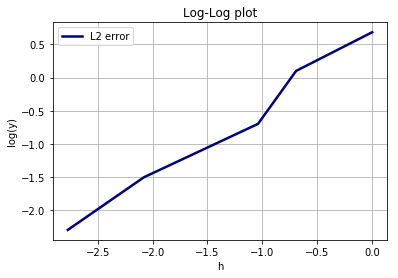

In [402]:
xlog = log(E[:,0])
ylog = log(E[:,1])
ax = plt.gca()
plt.plot(xlog, ylog, linewidth=2.5, color='navy', label=r'L2 error')
plt.legend(loc='best')
plt.xlabel(r'h')
plt.ylabel(r'log(y)')
ax.grid(True)
plt.title(r'Log-Log plot')
plt.show()
plt.clf()

The adaptative mesh refinement I am impleting to handle the L-shape domain is not working. However, I have problems defining my triangulations. However,I've been playing with Seth's idea, I think I can make it work. Also, I am interested in how to vectorize all this finite element implementation.

In [ ]:
#This is an implementation for the mass matrix that I was trying to use to calculate the error.

def massmatrix(vertices):
  # Mass Matrix  
    M = column_stack((ones((3,1)),vertices))

    x1 = 2/3*vertices[0] + 1/6*vertices[1] + 1/6*vertices[2]
    x2 = 1/6*vertices[0] + 2/3*vertices[1] + 1/6*vertices[2]
    x3 = 1/6*vertices[0] + 1/6*vertices[1] + 2/3*vertices[2]

    Mass = 1/6*abs(det(transpose(M)))*square(inv(M)@vstack( ( ones((1,3)),transpose(vstack((x1,x2,x3))))  ))
    return Mass